In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import cv2, random
from pathlib import Path
import dataclasses

from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.utils.visualizer import ColorMode
from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import Visualizer
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.data import detection_utils as utils
from detectron2.evaluation import COCOEvaluator, inference_on_dataset


from warnings import filterwarnings
filterwarnings("ignore")

import os
import sys
sys.path.append(os.path.join(str(os.path.abspath('')), "..", "..", "..", ".."))
from src.detector.get_dicts import get_COVID19_data_dicts
from src.detector.custom_trainer import MyTrainer
from src.detector.flags import Flags
from src.detector.save_yaml import save_yaml


setup_logger()

<Logger detectron2 (DEBUG)>

In [2]:
flags_dict = {
    "debug": False,
    "fold": 0,
    "outdir": "results/", 
    "root_imgdir": PATH_TO_IMAGES, # !!! DEFINE "PATH_TO_IMAGES" on your local machine,
    "path_to_meta_df": "../../cross_validation_scheme/modified_detectron_data/meta_df.csv",
    "path_to_train_df": "../../cross_validation_scheme/modified_detectron_data/detectron_prepared_df.csv",
    "use_cache": False,
    "img_size": "1024x1024",
    "cv_scheme": "skf",
    "use_negative": False,
    "binary_task": True,
    
    "iter": 4000,
    "roi_batch_size_per_image": 256,
    "eval_period": 1000,
#     "lr_scheduler_name": "WarmupMultiStepLR",
    "lr_scheduler_name": "WarmupCosineLR",
    "base_lr": 0.0025,
    "num_workers": 4,
    "ims_per_batch": 8,
    
    "aug_kwargs": {
        "HorizontalFlip": {"p": 0.5},
        "ShiftScaleRotate": {"scale_limit": 0.15, "rotate_limit": 10, "p": 0.5},
        "HueSaturationValue": {"hue_shift_limit": 10, "sat_shift_limit": 10, "val_shift_limit": 10, "p": 0.5},
        "RandomBrightnessContrast": {"p": 0.5},
        "CLAHE": {"clip_limit": (1,4), "p": 0.5},
        "GaussianBlur": {"p": 0.5}
    },
}

In [3]:
flags = Flags().update(flags_dict)
debug = flags.debug
outdir = Path(flags.outdir)
os.makedirs(str(outdir), exist_ok=True)
flags_dict = dataclasses.asdict(flags)
save_yaml(outdir / "flags.yaml", flags_dict)

In [4]:
thing_classes = [
    "opacity"
]

In [5]:
DatasetCatalog.register(
    "COVID19_data_train",
    lambda: get_COVID19_data_dicts(
                                    root_imgdir=flags.root_imgdir,
                                    path_to_meta_df=flags.path_to_meta_df,
                                    path_to_train_df=flags.path_to_train_df,
                                    use_cache=flags.use_cache,
                                    debug=flags.debug,
                                    img_size=flags.img_size,
                                    cv_scheme=flags.cv_scheme,
                                    use_negative=flags.use_negative,
                                    binary_task=flags.binary_task,
                                    mode='train',
                                    fold=flags.fold,
                                  ),
)
MetadataCatalog.get("COVID19_data_train").set(thing_classes=thing_classes)


DatasetCatalog.register(
    "COVID19_data_valid",
    lambda: get_COVID19_data_dicts(
                                    root_imgdir=flags.root_imgdir,
                                    path_to_meta_df=flags.path_to_meta_df,
                                    path_to_train_df=flags.path_to_train_df,
                                    use_cache=flags.use_cache,
                                    debug=flags.debug,
                                    img_size=flags.img_size,
                                    cv_scheme=flags.cv_scheme,
                                    use_negative=flags.use_negative,
                                    binary_task=flags.binary_task,
                                    mode='val',
                                    fold=flags.fold,
                                  ),
    )
MetadataCatalog.get("COVID19_data_valid").set(thing_classes=thing_classes)

dataset_dicts_train = DatasetCatalog.get("COVID19_data_train")
metadata_dicts_train = MetadataCatalog.get("COVID19_data_train")

dataset_dicts_valid = DatasetCatalog.get("COVID19_data_valid")
metadata_dicts_valid = MetadataCatalog.get("COVID19_data_valid")

  2%|▏         | 80/4819 [00:00<00:05, 791.91it/s]

Creating data...
/home/hdd/storage/siim_covid_detection/resized_images_from_kaggle/1024x1024/train/000c3a3f293f.jpg
image shape: (1024, 1024, 3)


  7%|▋         | 80/1211 [00:00<00:01, 792.11it/s]

Load from cache dataset_dicts_cache_train_cv_scheme_skf_fold_0_img_size_1024x1024_binary_task_True_use_negative_False.pkl
Creating data...
/home/hdd/storage/siim_covid_detection/resized_images_from_kaggle/1024x1024/train/000a312787f2.jpg
image shape: (1024, 1024, 3)


100%|██████████| 1211/1211 [00:01<00:00, 795.13it/s]

Load from cache dataset_dicts_cache_val_cv_scheme_skf_fold_0_img_size_1024x1024_binary_task_True_use_negative_False.pkl


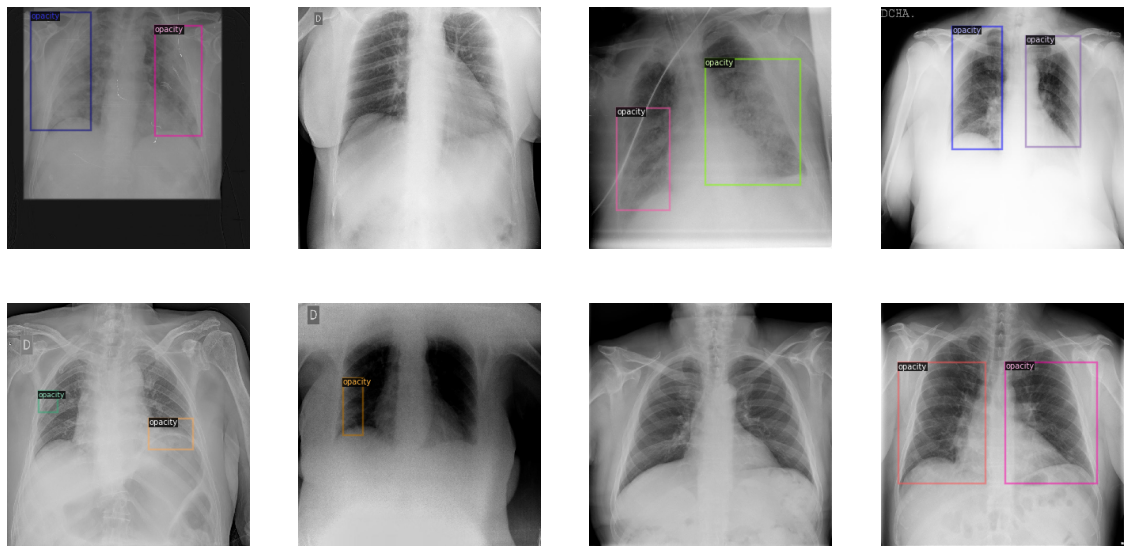

In [6]:
fig, ax = plt.subplots(2, 4, figsize =(20,10))
indices=[ax[0][0],ax[1][0],ax[0][1],ax[1][1],ax[0][2],ax[1][2],ax[0][3],ax[1][3]]
i=-1
for d in random.sample(dataset_dicts_train, 8):
    i=i+1    
    img = cv2.imread(d["file_name"])
    v = Visualizer(img[:, :, ::-1],
                   metadata=metadata_dicts_train, 
                   scale=0.3, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_dataset_dict(d)
    indices[i].grid(False)
    indices[i].axis('off')
    indices[i].imshow(out.get_image()[:, :, ::-1])

In [7]:
from detectron2.config.config import CfgNode as CN

cfg = get_cfg()
cfg.aug_kwargs = CN(flags.aug_kwargs)  # pass aug_kwargs to cfg

original_output_dir = cfg.OUTPUT_DIR
cfg.OUTPUT_DIR = flags.outdir
print(f"cfg.OUTPUT_DIR {original_output_dir} -> {cfg.OUTPUT_DIR}")

config_name = "COCO-Detection/retinanet_R_101_FPN_3x.yaml"
cfg.merge_from_file(model_zoo.get_config_file(config_name))
cfg.DATASETS.TRAIN = ("COVID19_data_train",)
cfg.DATASETS.TEST = ("COVID19_data_valid",)
cfg.TEST.EVAL_PERIOD = flags.eval_period

cfg.DATALOADER.NUM_WORKERS = flags.num_workers
# Let training initialize from model zoo
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(config_name)
cfg.SOLVER.IMS_PER_BATCH = flags.ims_per_batch
cfg.SOLVER.LR_SCHEDULER_NAME = flags.lr_scheduler_name
cfg.SOLVER.BASE_LR = flags.base_lr  # pick a good LR
cfg.SOLVER.MAX_ITER = flags.iter
cfg.SOLVER.CHECKPOINT_PERIOD = 100000  # Small value=Frequent save need a lot of storage.
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = flags.roi_batch_size_per_image
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(thing_classes)
# NOTE: this config means the number of classes,
# but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

Loading config /home/greylord/siim_covid/covid_env/lib/python3.8/site-packages/detectron2/model_zoo/configs/COCO-Detection/../Base-RetinaNet.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


cfg.OUTPUT_DIR ./output -> results/


In [8]:
trainer = MyTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[07/30 15:49:26 d2.engine.defaults]: Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2)

  2%|▏         | 77/4819 [00:00<00:06, 767.98it/s]

[AlbumentationsMapper] Augmentations used in training: Compose([
  HorizontalFlip(always_apply=False, p=0.5),
  ShiftScaleRotate(always_apply=False, p=0.5, shift_limit_x=(-0.0625, 0.0625), shift_limit_y=(-0.0625, 0.0625), scale_limit=(-0.15000000000000002, 0.1499999999999999), rotate_limit=(-10, 10), interpolation=1, border_mode=4, value=None, mask_value=None),
  HueSaturationValue(always_apply=False, p=0.5, hue_shift_limit=(-10, 10), sat_shift_limit=(-10, 10), val_shift_limit=(-10, 10)),
  RandomBrightnessContrast(always_apply=False, p=0.5, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), brightness_by_max=True),
  CLAHE(always_apply=False, p=0.5, clip_limit=(1, 4), tile_grid_size=(8, 8)),
  GaussianBlur(always_apply=False, p=0.5, blur_limit=(3, 7), sigma_limit=(0, 0)),
], p=1.0, bbox_params={'format': 'pascal_voc', 'label_fields': ['category_ids'], 'min_area': 0.0, 'min_visibility': 0.0, 'check_each_transform': True}, keypoint_params=None, additional_targets={})
Creating dat

100%|██████████| 4819/4819 [00:06<00:00, 795.33it/s]


Load from cache dataset_dicts_cache_train_cv_scheme_skf_fold_0_img_size_1024x1024_binary_task_True_use_negative_False.pkl
[07/30 15:49:32 d2.data.build]: Removed 1389 images with no usable annotations. 3430 images left.
[07/30 15:49:32 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|  opacity   | 6266         |
|            |              |
[07/30 15:49:32 d2.data.build]: Using training sampler TrainingSampler
[07/30 15:49:32 d2.data.common]: Serializing 3430 elements to byte tensors and concatenating them all ...
[07/30 15:49:32 d2.data.common]: Serialized dataset takes 1.20 MiB


  0%|          | 0/1211 [00:00<?, ?it/s]

[AlbumentationsMapper] Augmentations used in inference: Compose([
], p=1.0, bbox_params={'format': 'pascal_voc', 'label_fields': ['category_ids'], 'min_area': 0.0, 'min_visibility': 0.0, 'check_each_transform': True}, keypoint_params=None, additional_targets={})
Creating data...
/home/hdd/storage/siim_covid_detection/resized_images_from_kaggle/1024x1024/train/000a312787f2.jpg
image shape: (1024, 1024, 3)


100%|██████████| 1211/1211 [00:01<00:00, 792.88it/s]

Load from cache dataset_dicts_cache_val_cv_scheme_skf_fold_0_img_size_1024x1024_binary_task_True_use_negative_False.pkl
[07/30 15:49:33 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|  opacity   | 1586         |
|            |              |
[07/30 15:49:33 d2.data.common]: Serializing 1211 elements to byte tensors and concatenating them all ...
[07/30 15:49:33 d2.data.common]: Serialized dataset takes 0.37 MiB


[07/30 15:49:34 d2.engine.train_loop]: Starting training from iteration 0
[07/30 15:49:55 d2.utils.events]:  eta: 1:09:14  iter: 19  total_loss: 1.981  loss_cls: 1.19  loss_box_reg: 0.8303  time: 1.0633  data_time: 0.0291  lr: 4.2996e-05  max_mem: 18669M
[07/30 15:50:16 d2.utils.events]:  eta: 1:09:13  iter: 39  total_loss: 1.113  loss_cls: 0.5327  loss_box_reg: 0.5925  time: 1.0588  data_time: 0.0151  lr: 8.5624e-05  max_mem: 18669M
[07/30 15:50:37 d2.utils.events]:  eta: 1:08:53  iter: 59  total_loss: 0.9687  loss_cls: 0.4566  loss_box_reg: 0.5081  time: 1.0554  data_time: 0.0146  lr: 0.00012825  max_mem: 18669M
[07/30 15:51:00 d2.utils.events]:  eta: 1:08:33  iter: 79  total_loss: 0.9607  loss_cls: 0.4465  loss_box_reg: 0.5225  time: 1.0690  data_time: 0.0147  lr: 0.00017088  max_mem: 18669M
[07/30 15:51:21 d2.utils.events]:  eta: 1:08:15  iter: 99  total_loss: 0.8942  loss_cls: 0.4036  loss_box_reg: 0.4869  time: 1.0658  data_time: 0.0153  lr: 0.00021351  max_mem: 18669M
[07/30 15:

[07/30 16:05:03 d2.utils.events]:  eta: 0:54:42  iter: 879  total_loss: 0.7723  loss_cls: 0.3396  loss_box_reg: 0.4396  time: 1.0549  data_time: 0.0150  lr: 0.001876  max_mem: 18669M
[07/30 16:05:24 d2.utils.events]:  eta: 0:54:21  iter: 899  total_loss: 0.7779  loss_cls: 0.3343  loss_box_reg: 0.4413  time: 1.0547  data_time: 0.0157  lr: 0.0019186  max_mem: 18669M
[07/30 16:05:45 d2.utils.events]:  eta: 0:54:00  iter: 919  total_loss: 0.7171  loss_cls: 0.2853  loss_box_reg: 0.4164  time: 1.0547  data_time: 0.0157  lr: 0.0019612  max_mem: 18669M
[07/30 16:06:06 d2.utils.events]:  eta: 0:53:39  iter: 939  total_loss: 0.7047  loss_cls: 0.3048  loss_box_reg: 0.4095  time: 1.0546  data_time: 0.0162  lr: 0.0020039  max_mem: 18669M
[07/30 16:06:27 d2.utils.events]:  eta: 0:53:17  iter: 959  total_loss: 0.7978  loss_cls: 0.3547  loss_box_reg: 0.4414  time: 1.0544  data_time: 0.0150  lr: 0.0020465  max_mem: 18669M
[07/30 16:06:48 d2.utils.events]:  eta: 0:52:56  iter: 979  total_loss: 0.7964  l

  7%|▋         | 81/1211 [00:00<00:01, 806.69it/s]

[AlbumentationsMapper] Augmentations used in inference: Compose([
], p=1.0, bbox_params={'format': 'pascal_voc', 'label_fields': ['category_ids'], 'min_area': 0.0, 'min_visibility': 0.0, 'check_each_transform': True}, keypoint_params=None, additional_targets={})
Creating data...
/home/hdd/storage/siim_covid_detection/resized_images_from_kaggle/1024x1024/train/000a312787f2.jpg
image shape: (1024, 1024, 3)


100%|██████████| 1211/1211 [00:01<00:00, 816.54it/s]


Load from cache dataset_dicts_cache_val_cv_scheme_skf_fold_0_img_size_1024x1024_binary_task_True_use_negative_False.pkl
[07/30 16:07:10 d2.data.common]: Serializing 1211 elements to byte tensors and concatenating them all ...
[07/30 16:07:10 d2.data.common]: Serialized dataset takes 0.37 MiB
[07/30 16:07:10 d2.evaluation.coco_evaluation]: 'COVID19_data_valid' is not registered by `register_coco_instances`. Therefore trying to convert it to COCO format ...
[07/30 16:07:10 d2.data.datasets.coco]: Converting annotations of dataset 'COVID19_data_valid' to COCO format ...)


  7%|▋         | 79/1211 [00:00<00:01, 787.80it/s]

Creating data...
/home/hdd/storage/siim_covid_detection/resized_images_from_kaggle/1024x1024/train/000a312787f2.jpg
image shape: (1024, 1024, 3)


100%|██████████| 1211/1211 [00:01<00:00, 826.46it/s]

Load from cache dataset_dicts_cache_val_cv_scheme_skf_fold_0_img_size_1024x1024_binary_task_True_use_negative_False.pkl
[07/30 16:07:12 d2.data.datasets.coco]: Converting dataset dicts into COCO format


[07/30 16:07:12 d2.data.datasets.coco]: Conversion finished, #images: 1211, #annotations: 1586
[07/30 16:07:12 d2.data.datasets.coco]: Caching COCO format annotations at 'results/inference/COVID19_data_valid_coco_format.json' ...
[07/30 16:07:12 d2.evaluation.evaluator]: Start inference on 1211 images
[07/30 16:07:13 d2.evaluation.evaluator]: Inference done 11/1211. 0.0531 s / img. ETA=0:01:05
[07/30 16:07:18 d2.evaluation.evaluator]: Inference done 102/1211. 0.0535 s / img. ETA=0:01:01
[07/30 16:07:23 d2.evaluation.evaluator]: Inference done 193/1211. 0.0535 s / img. ETA=0:00:56
[07/30 16:07:28 d2.evaluation.evaluator]: Inference done 282/1211. 0.0535 s / img. ETA=0:00:51
[07/30 16:07:33 d2.evaluation.evaluator]: Inference done 373/1211. 0.0534 s / img. ETA=0:00:46
[07/30 16:07:38 d2.evaluation.evaluator]: Inference done 464/1211. 0.0534 s / img. ETA=0:00:41
[07/30 16:07:43 d2.evaluation.evaluator]: Inference done 554/1211. 0.0535 s / img. ETA=0:00:36
[07/30 16:07:48 d2.evaluation.eva

[07/30 16:15:34 d2.utils.events]:  eta: 0:46:34  iter: 1339  total_loss: 0.7364  loss_cls: 0.3111  loss_box_reg: 0.4326  validation_loss: 0.7927  time: 1.0531  data_time: 0.0159  lr: 0.0018702  max_mem: 18669M
[07/30 16:15:55 d2.utils.events]:  eta: 0:46:13  iter: 1359  total_loss: 0.719  loss_cls: 0.2854  loss_box_reg: 0.4323  validation_loss: 0.7927  time: 1.0530  data_time: 0.0162  lr: 0.0018531  max_mem: 18669M
[07/30 16:16:16 d2.utils.events]:  eta: 0:45:52  iter: 1379  total_loss: 0.7525  loss_cls: 0.3112  loss_box_reg: 0.4232  validation_loss: 0.7927  time: 1.0530  data_time: 0.0158  lr: 0.0018358  max_mem: 18669M
[07/30 16:16:37 d2.utils.events]:  eta: 0:45:31  iter: 1399  total_loss: 0.7452  loss_cls: 0.3176  loss_box_reg: 0.4387  validation_loss: 0.7927  time: 1.0530  data_time: 0.0158  lr: 0.0018184  max_mem: 18669M
[07/30 16:16:58 d2.utils.events]:  eta: 0:45:10  iter: 1419  total_loss: 0.7559  loss_cls: 0.3284  loss_box_reg: 0.4213  validation_loss: 0.7927  time: 1.0529  d

  7%|▋         | 83/1211 [00:00<00:01, 828.11it/s]

[AlbumentationsMapper] Augmentations used in inference: Compose([
], p=1.0, bbox_params={'format': 'pascal_voc', 'label_fields': ['category_ids'], 'min_area': 0.0, 'min_visibility': 0.0, 'check_each_transform': True}, keypoint_params=None, additional_targets={})
Creating data...
/home/hdd/storage/siim_covid_detection/resized_images_from_kaggle/1024x1024/train/000a312787f2.jpg
image shape: (1024, 1024, 3)


100%|██████████| 1211/1211 [00:01<00:00, 826.95it/s]

Load from cache dataset_dicts_cache_val_cv_scheme_skf_fold_0_img_size_1024x1024_binary_task_True_use_negative_False.pkl
[07/30 16:27:09 d2.data.common]: Serializing 1211 elements to byte tensors and concatenating them all ...
[07/30 16:27:09 d2.data.common]: Serialized dataset takes 0.37 MiB
[07/30 16:27:09 d2.evaluation.evaluator]: Start inference on 1211 images


[07/30 16:27:09 d2.evaluation.evaluator]: Inference done 11/1211. 0.0534 s / img. ETA=0:01:05
[07/30 16:27:14 d2.evaluation.evaluator]: Inference done 102/1211. 0.0532 s / img. ETA=0:01:00
[07/30 16:27:19 d2.evaluation.evaluator]: Inference done 193/1211. 0.0532 s / img. ETA=0:00:56
[07/30 16:27:24 d2.evaluation.evaluator]: Inference done 284/1211. 0.0532 s / img. ETA=0:00:51
[07/30 16:27:29 d2.evaluation.evaluator]: Inference done 374/1211. 0.0534 s / img. ETA=0:00:46
[07/30 16:27:34 d2.evaluation.evaluator]: Inference done 465/1211. 0.0533 s / img. ETA=0:00:41
[07/30 16:27:39 d2.evaluation.evaluator]: Inference done 556/1211. 0.0533 s / img. ETA=0:00:36
[07/30 16:27:44 d2.evaluation.evaluator]: Inference done 647/1211. 0.0533 s / img. ETA=0:00:31
[07/30 16:27:49 d2.evaluation.evaluator]: Inference done 738/1211. 0.0533 s / img. ETA=0:00:26
[07/30 16:27:55 d2.evaluation.evaluator]: Inference done 829/1211. 0.0533 s / img. ETA=0:00:21
[07/30 16:28:00 d2.evaluation.evaluator]: Inference

[07/30 16:36:11 d2.utils.events]:  eta: 0:28:18  iter: 2379  total_loss: 0.7069  loss_cls: 0.2961  loss_box_reg: 0.4081  validation_loss: 0.7676  time: 1.0515  data_time: 0.0163  lr: 0.00088339  max_mem: 18669M
[07/30 16:36:32 d2.utils.events]:  eta: 0:27:57  iter: 2399  total_loss: 0.7367  loss_cls: 0.3087  loss_box_reg: 0.4172  validation_loss: 0.7676  time: 1.0515  data_time: 0.0164  lr: 0.00086466  max_mem: 18669M
[07/30 16:36:53 d2.utils.events]:  eta: 0:27:36  iter: 2419  total_loss: 0.7108  loss_cls: 0.3042  loss_box_reg: 0.4172  validation_loss: 0.7676  time: 1.0515  data_time: 0.0160  lr: 0.00084603  max_mem: 18669M
[07/30 16:37:14 d2.utils.events]:  eta: 0:27:15  iter: 2439  total_loss: 0.7177  loss_cls: 0.2942  loss_box_reg: 0.4212  validation_loss: 0.7676  time: 1.0515  data_time: 0.0171  lr: 0.0008275  max_mem: 18669M
[07/30 16:37:35 d2.utils.events]:  eta: 0:26:54  iter: 2459  total_loss: 0.7261  loss_cls: 0.2926  loss_box_reg: 0.4277  validation_loss: 0.7676  time: 1.051

  7%|▋         | 80/1211 [00:00<00:01, 793.58it/s]

[AlbumentationsMapper] Augmentations used in inference: Compose([
], p=1.0, bbox_params={'format': 'pascal_voc', 'label_fields': ['category_ids'], 'min_area': 0.0, 'min_visibility': 0.0, 'check_each_transform': True}, keypoint_params=None, additional_targets={})
Creating data...
/home/hdd/storage/siim_covid_detection/resized_images_from_kaggle/1024x1024/train/000a312787f2.jpg
image shape: (1024, 1024, 3)


100%|██████████| 1211/1211 [00:01<00:00, 789.22it/s]

Load from cache dataset_dicts_cache_val_cv_scheme_skf_fold_0_img_size_1024x1024_binary_task_True_use_negative_False.pkl
[07/30 16:47:04 d2.data.common]: Serializing 1211 elements to byte tensors and concatenating them all ...
[07/30 16:47:04 d2.data.common]: Serialized dataset takes 0.37 MiB
[07/30 16:47:04 d2.evaluation.evaluator]: Start inference on 1211 images


[07/30 16:47:05 d2.evaluation.evaluator]: Inference done 11/1211. 0.0531 s / img. ETA=0:01:05
[07/30 16:47:10 d2.evaluation.evaluator]: Inference done 102/1211. 0.0531 s / img. ETA=0:01:00
[07/30 16:47:15 d2.evaluation.evaluator]: Inference done 192/1211. 0.0534 s / img. ETA=0:00:56
[07/30 16:47:20 d2.evaluation.evaluator]: Inference done 283/1211. 0.0533 s / img. ETA=0:00:51
[07/30 16:47:25 d2.evaluation.evaluator]: Inference done 374/1211. 0.0533 s / img. ETA=0:00:46
[07/30 16:47:30 d2.evaluation.evaluator]: Inference done 465/1211. 0.0532 s / img. ETA=0:00:41
[07/30 16:47:35 d2.evaluation.evaluator]: Inference done 556/1211. 0.0532 s / img. ETA=0:00:36
[07/30 16:47:40 d2.evaluation.evaluator]: Inference done 647/1211. 0.0532 s / img. ETA=0:00:31
[07/30 16:47:45 d2.evaluation.evaluator]: Inference done 738/1211. 0.0532 s / img. ETA=0:00:26
[07/30 16:47:50 d2.evaluation.evaluator]: Inference done 829/1211. 0.0532 s / img. ETA=0:00:21
[07/30 16:47:55 d2.evaluation.evaluator]: Inference

[07/30 16:55:47 d2.utils.events]:  eta: 0:11:11  iter: 3359  total_loss: 0.6159  loss_cls: 0.2486  loss_box_reg: 0.3783  validation_loss: 0.7426  time: 1.0512  data_time: 0.0162  lr: 0.00015509  max_mem: 18669M
[07/30 16:56:08 d2.utils.events]:  eta: 0:10:50  iter: 3379  total_loss: 0.6354  loss_cls: 0.2574  loss_box_reg: 0.3779  validation_loss: 0.7426  time: 1.0512  data_time: 0.0162  lr: 0.00014575  max_mem: 18669M
[07/30 16:56:29 d2.utils.events]:  eta: 0:10:29  iter: 3399  total_loss: 0.6764  loss_cls: 0.2769  loss_box_reg: 0.3988  validation_loss: 0.7426  time: 1.0512  data_time: 0.0168  lr: 0.00013669  max_mem: 18669M
[07/30 16:56:50 d2.utils.events]:  eta: 0:10:08  iter: 3419  total_loss: 0.6748  loss_cls: 0.2659  loss_box_reg: 0.402  validation_loss: 0.7426  time: 1.0512  data_time: 0.0165  lr: 0.0001279  max_mem: 18669M
[07/30 16:57:11 d2.utils.events]:  eta: 0:09:47  iter: 3439  total_loss: 0.6795  loss_cls: 0.2653  loss_box_reg: 0.3937  validation_loss: 0.7426  time: 1.0512

  7%|▋         | 80/1211 [00:00<00:01, 799.84it/s]

[AlbumentationsMapper] Augmentations used in inference: Compose([
], p=1.0, bbox_params={'format': 'pascal_voc', 'label_fields': ['category_ids'], 'min_area': 0.0, 'min_visibility': 0.0, 'check_each_transform': True}, keypoint_params=None, additional_targets={})
Creating data...
/home/hdd/storage/siim_covid_detection/resized_images_from_kaggle/1024x1024/train/000a312787f2.jpg
image shape: (1024, 1024, 3)


100%|██████████| 1211/1211 [00:01<00:00, 800.63it/s]

Load from cache dataset_dicts_cache_val_cv_scheme_skf_fold_0_img_size_1024x1024_binary_task_True_use_negative_False.pkl
[07/30 17:07:01 d2.data.common]: Serializing 1211 elements to byte tensors and concatenating them all ...
[07/30 17:07:01 d2.data.common]: Serialized dataset takes 0.37 MiB
[07/30 17:07:01 d2.evaluation.evaluator]: Start inference on 1211 images


[07/30 17:07:02 d2.evaluation.evaluator]: Inference done 11/1211. 0.0535 s / img. ETA=0:01:05
[07/30 17:07:07 d2.evaluation.evaluator]: Inference done 102/1211. 0.0532 s / img. ETA=0:01:01
[07/30 17:07:12 d2.evaluation.evaluator]: Inference done 192/1211. 0.0536 s / img. ETA=0:00:56
[07/30 17:07:17 d2.evaluation.evaluator]: Inference done 283/1211. 0.0535 s / img. ETA=0:00:51
[07/30 17:07:22 d2.evaluation.evaluator]: Inference done 374/1211. 0.0534 s / img. ETA=0:00:46
[07/30 17:07:27 d2.evaluation.evaluator]: Inference done 465/1211. 0.0534 s / img. ETA=0:00:41
[07/30 17:07:32 d2.evaluation.evaluator]: Inference done 556/1211. 0.0533 s / img. ETA=0:00:36
[07/30 17:07:37 d2.evaluation.evaluator]: Inference done 647/1211. 0.0533 s / img. ETA=0:00:31
[07/30 17:07:42 d2.evaluation.evaluator]: Inference done 738/1211. 0.0533 s / img. ETA=0:00:26
[07/30 17:07:47 d2.evaluation.evaluator]: Inference done 829/1211. 0.0533 s / img. ETA=0:00:21
[07/30 17:07:52 d2.evaluation.evaluator]: Inference

  6%|▋         | 78/1211 [00:00<00:01, 774.96it/s]

[AlbumentationsMapper] Augmentations used in inference: Compose([
], p=1.0, bbox_params={'format': 'pascal_voc', 'label_fields': ['category_ids'], 'min_area': 0.0, 'min_visibility': 0.0, 'check_each_transform': True}, keypoint_params=None, additional_targets={})
Creating data...
/home/hdd/storage/siim_covid_detection/resized_images_from_kaggle/1024x1024/train/000a312787f2.jpg
image shape: (1024, 1024, 3)


100%|██████████| 1211/1211 [00:01<00:00, 786.81it/s]

Load from cache dataset_dicts_cache_val_cv_scheme_skf_fold_0_img_size_1024x1024_binary_task_True_use_negative_False.pkl
[07/30 17:09:27 d2.data.common]: Serializing 1211 elements to byte tensors and concatenating them all ...
[07/30 17:09:27 d2.data.common]: Serialized dataset takes 0.37 MiB
[07/30 17:09:27 d2.evaluation.evaluator]: Start inference on 1211 images


[07/30 17:09:28 d2.evaluation.evaluator]: Inference done 11/1211. 0.0532 s / img. ETA=0:01:05
[07/30 17:09:33 d2.evaluation.evaluator]: Inference done 102/1211. 0.0532 s / img. ETA=0:01:00
[07/30 17:09:38 d2.evaluation.evaluator]: Inference done 193/1211. 0.0532 s / img. ETA=0:00:55
[07/30 17:09:43 d2.evaluation.evaluator]: Inference done 284/1211. 0.0532 s / img. ETA=0:00:51
[07/30 17:09:48 d2.evaluation.evaluator]: Inference done 374/1211. 0.0532 s / img. ETA=0:00:46
[07/30 17:09:53 d2.evaluation.evaluator]: Inference done 465/1211. 0.0532 s / img. ETA=0:00:41
[07/30 17:09:58 d2.evaluation.evaluator]: Inference done 556/1211. 0.0532 s / img. ETA=0:00:36
[07/30 17:10:03 d2.evaluation.evaluator]: Inference done 647/1211. 0.0532 s / img. ETA=0:00:31
[07/30 17:10:08 d2.evaluation.evaluator]: Inference done 738/1211. 0.0532 s / img. ETA=0:00:26
[07/30 17:10:13 d2.evaluation.evaluator]: Inference done 829/1211. 0.0532 s / img. ETA=0:00:21
[07/30 17:10:18 d2.evaluation.evaluator]: Inference

In [15]:
evaluator = COCOEvaluator("COVID19_data_train", cfg, False, output_dir="./results")
val_loader = build_detection_test_loader(cfg, "COVID19_data_train")
inference_on_dataset(trainer.model, val_loader, evaluator)

WARNING [07/30 18:20:45 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.


  0%|          | 0/4819 [00:00<?, ?it/s]

Creating data...
/home/hdd/storage/siim_covid_detection/resized_images_from_kaggle/1024x1024/train/000c3a3f293f.jpg
image shape: (1024, 1024, 3)


100%|██████████| 4819/4819 [00:06<00:00, 777.18it/s]


Load from cache dataset_dicts_cache_train_cv_scheme_skf_fold_0_img_size_1024x1024_binary_task_True_use_negative_False.pkl
[07/30 18:20:52 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[07/30 18:20:52 d2.data.common]: Serializing 4819 elements to byte tensors and concatenating them all ...
[07/30 18:20:52 d2.data.common]: Serialized dataset takes 1.46 MiB
[07/30 18:20:52 d2.evaluation.evaluator]: Start inference on 4819 images
[07/30 18:20:53 d2.evaluation.evaluator]: Inference done 11/4819. 0.0427 s / img. ETA=0:03:28
[07/30 18:20:58 d2.evaluation.evaluator]: Inference done 139/4819. 0.0385 s / img. ETA=0:03:04
[07/30 18:21:03 d2.evaluation.evaluator]: Inference done 274/4819. 0.0374 s / img. ETA=0:02:53
[07/30 18:21:08 d2.evaluation.evaluator]: Inference done 412/4819. 0.0368 s / img. ETA=0:02:45
[07/30 18:21:13 d2.evaluation.evaluator]: Inference done 549/4819. 0.0366 

OrderedDict([('bbox',
              {'AP': 18.979441606395515,
               'AP50': 55.68474213131416,
               'AP75': 7.329571979970523,
               'APs': nan,
               'APm': 4.160766351396815,
               'APl': 19.17122347933235})])

In [10]:
metrics_df = pd.read_json("results/metrics.json", orient="records", lines=True)
mdf = metrics_df.sort_values("iteration")
mdf

,data_time,eta_seconds,iteration,loss_box_reg,loss_cls,lr,num_pos_anchors,time,total_loss,bbox/AP,bbox/AP50,bbox/AP75,bbox/APl,bbox/APm,bbox/APs,validation_loss
0,0.015769,4154.287388,19,0.830319,1.189820,4.299629e-05,48.4375,1.043791,1.980776,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.014559,4153.413158,39,0.592509,0.532732,8.562396e-05,52.7500,1.053092,1.112685,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.014150,4133.206139,59,0.508125,0.456645,1.282516e-04,51.5625,1.049161,0.968704,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.014279,4113.028799,79,0.522490,0.446524,1.708793e-04,52.1875,1.052081,0.960670,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.014924,4095.505110,99,0.486865,0.403611,2.135070e-04,54.1875,1.053009,0.894247,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,0.015864,62.990344,3939,0.411363,0.274319,1.434288e-06,52.7500,1.049600,0.679753,NaN,NaN,NaN,NaN,NaN,NaN,NaN
197,0.016877,42.000427,3959,0.374399,0.257097,6.480223e-07,51.1250,1.053243,0.634770,NaN,NaN,NaN,NaN,NaN,NaN,NaN
198,0.015898,21.000483,3979,0.418204,0.301544,1.700155e-07,53.9375,1.050783,0.726925,NaN,NaN,NaN,NaN,NaN,NaN,NaN
199,0.015889,0.000000,3999,0.397352,0.275087,3.855314e-10,49.5000,1.051147,0.683844,18.333292,55.481288,6.75936,18.632394,1.035545,NaN,0.738108


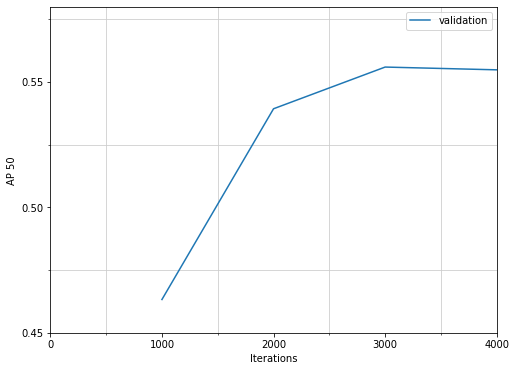

In [17]:
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

fig, ax = plt.subplots(figsize=(8, 6))

# Set axis ranges; by default this will put major ticks every 25.
ax.set_xlim(0, 4000)
ax.set_ylim(0.45, 0.58)

# Change major ticks to show every 20.
ax.xaxis.set_major_locator(MultipleLocator(1000))
ax.yaxis.set_major_locator(MultipleLocator(0.05))

# Change minor ticks to show every 5. (20/4 = 5)
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))

# Turn grid on for both major and minor ticks and style minor slightly
# differently.
ax.grid(which='major', color='#CCCCCC')
ax.grid(which='minor', color='#CCCCCC')


# plt.title("UnEfficientNet-B4 Training")
plt.xlabel("Iterations")
plt.ylabel("AP 50")

mdf3 = mdf[~mdf["bbox/AP50"].isna()]
plt.plot(mdf3["iteration"], mdf3["bbox/AP50"] / 100., label='validation')
plt.grid()
plt.legend()
plt.show() 
fig.savefig("results/AP50.png")

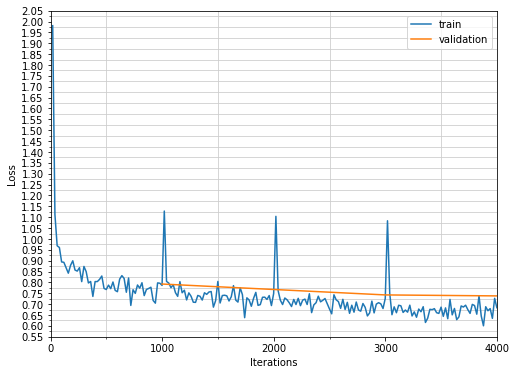

In [16]:
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

fig, ax = plt.subplots(figsize=(8, 6))

# Set axis ranges; by default this will put major ticks every 25.
ax.set_xlim(0, 4000)
ax.set_ylim(0.55, 2.05)

# Change major ticks to show every 20.
ax.xaxis.set_major_locator(MultipleLocator(1000))
ax.yaxis.set_major_locator(MultipleLocator(0.05))

# Change minor ticks to show every 5. (20/4 = 5)
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))

# Turn grid on for both major and minor ticks and style minor slightly
# differently.
ax.grid(which='major', color='#CCCCCC')
ax.grid(which='minor', color='#CCCCCC')


# plt.title("UnEfficientNet-B4 Training")
plt.xlabel("Iterations")
plt.ylabel("Loss")

# plt.plot(mdf3["iteration"], mdf3["bbox/AP50"] / 100., label='validation')

mdf1 = mdf[~mdf["total_loss"].isna()]
plt.plot(mdf1["iteration"], mdf1["total_loss"], c="C0", label="train")
if "validation_loss" in mdf.columns:
    mdf2 = mdf[~mdf["validation_loss"].isna()]
    plt.plot(mdf2["iteration"], mdf2["validation_loss"], c="C1", label="validation")
plt.grid()
plt.legend()
plt.show() 
fig.savefig("results/loss.png")